[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...


Loaded 18 documents from /Users/user/Desktop/GAITAR-hashed

Top keywords per topic:
Topic_1: homes, nile, alexandria, river, temples
Topic_2: rich, accurate, understanding, history, political
Topic_3: would, image, see, often, people
Topic_4: antony, caesar, political, julius, mark
Saved topic & sentiment data to: /Users/user/Desktop/GAITAR-hashed/topic_sentiment.csv

Keyword-in-Context Samples:

=== Topic_1 Concordances ===

Concordance for 'homes':
Displaying 5 of 20 matches:
bilities how were egyptian homes built differently from gre
ilt differently from greek homes egyptian and greek homes h
k homes egyptian and greek homes had distinct architectural
onmental contexts egyptian homes materials egyptian homes w
n homes materials egyptian homes were primarily built using

Concordance for 'nile':
Displaying 5 of 27 matches:
t includes the pyramids and nile river along with many worke
 readily available from the nile s floodplains this material
eopatra s egypt how did the nile river sha

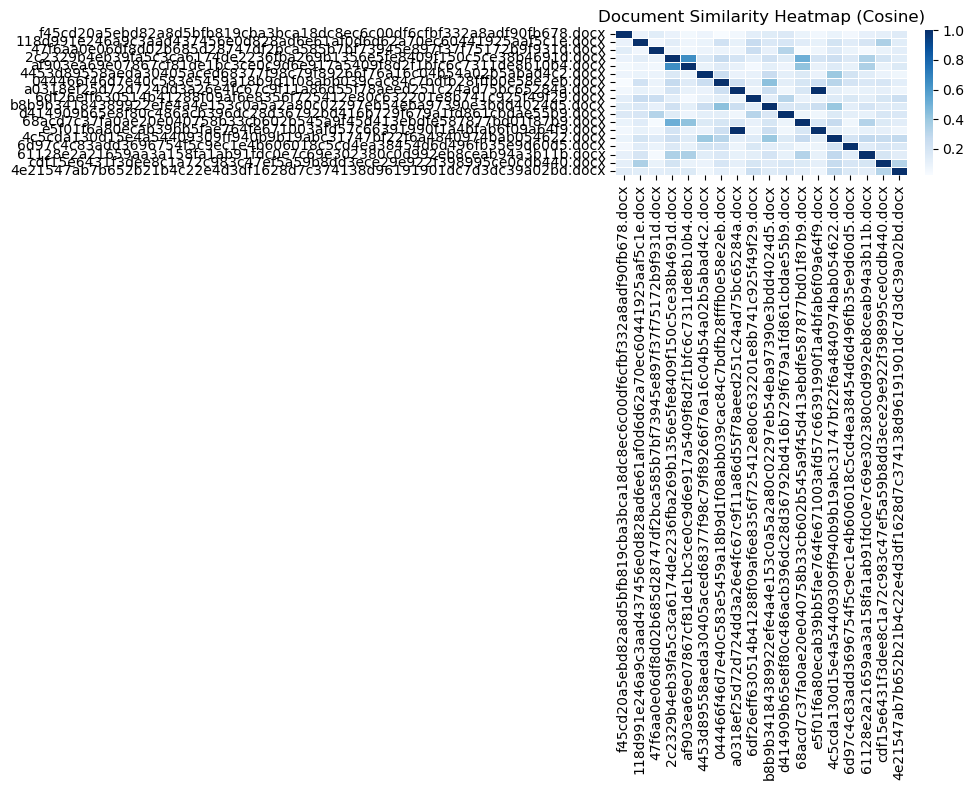

In [1]:
# ================================================
# Topic Modeling + Sentiment + Concordance + Heatmap
# ================================================

import os
import re
import docx
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# 2) Load all .docx files from your local folder
folder_path = os.path.expanduser("~/Desktop/GAITAR-hashed")
docs = []
filenames = []
for fname in os.listdir(folder_path):
    if fname.lower().endswith(".docx"):
        path = os.path.join(folder_path, fname)
        doc = docx.Document(path)
        text = "\n".join(p.text for p in doc.paragraphs)
        docs.append(text)
        filenames.append(fname)
print(f"Loaded {len(docs)} documents from {folder_path}")

# 3) Clean & preprocess text
def clean(text):
    txt = text.lower()
    txt = re.sub(r'\d+', '', txt)               # remove numbers
    txt = re.sub(r'http\S+|\W+', ' ', txt)      # remove URLs & punctuation
    return txt

docs_clean = [clean(d) for d in docs]

# 4) Vectorize text (unigrams + bigrams)
stop_words = nltk.corpus.stopwords.words('english')
vectorizer = CountVectorizer(
    stop_words=stop_words,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)
dtm = vectorizer.fit_transform(docs_clean)

# 5) Fit LDA topic model
n_topics = 4    # adjust as desired
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=15,
    random_state=42
)
lda.fit(dtm)

# 6) Extract top keywords per topic
feature_names = vectorizer.get_feature_names_out()
top_n = 5
topic_keywords = {}
for t in range(n_topics):
    top_indices = lda.components_[t].argsort()[-top_n:][::-1]
    topic_keywords[f"Topic_{t+1}"] = [feature_names[i] for i in top_indices]

print("\nTop keywords per topic:")
for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")

# 7) Build document-topic distribution DataFrame
doc_topic_dist = lda.transform(dtm)
topic_df = pd.DataFrame(
    doc_topic_dist,
    columns=[f"Topic_{i+1}" for i in range(n_topics)]
)
topic_df['Filename'] = filenames

# 8) Sentiment analysis with VADER
sia = SentimentIntensityAnalyzer()
topic_df['Sentiment'] = [sia.polarity_scores(doc)['compound'] for doc in docs_clean]

# 9) Save topic weights + sentiment to CSV
out_csv = os.path.join(folder_path, "topic_sentiment.csv")
topic_df.to_csv(out_csv, index=False)
print(f"Saved topic & sentiment data to: {out_csv}")

# 10) Keyword-in-context (concordance) snapshots
print("\nKeyword-in-Context Samples:")
all_text = " ".join(docs_clean)
tokens = nltk.word_tokenize(all_text)
text_obj = nltk.Text(tokens)

for topic, keywords in topic_keywords.items():
    print(f"\n=== {topic} Concordances ===")
    for kw in keywords:
        print(f"\nConcordance for '{kw}':")
        text_obj.concordance(kw, width=60, lines=5)

# 11) Document similarity heatmap
sim_matrix = cosine_similarity(dtm)
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    xticklabels=filenames,
    yticklabels=filenames,
    cmap="Blues",
    linewidths=0.5
)
plt.title("Document Similarity Heatmap (Cosine)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()